In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')


Este proyecto tiene como objetivo entrenar un modelo de clasificación para detectar neumonía a partir de imágenes de rayos X utilizando técnicas de extracción de características y un modelo de máquina de soporte vectorial (SVM).

En este proyecto se utilizan dos extractores de características populares en visión por computadora: HOG (Histogram of Oriented Gradients) y LBP (Local Binary Pattern).

* **HOG (Histogram of Oriented Gradients)**: Este método se enfoca en capturar la información de los bordes y las formas estructurales de una imagen, analizando los gradientes de intensidad en diferentes direcciones. Es ideal para detectar las formas generales de los objetos, como los pulmones, y es robusto ante variaciones en la iluminación. HOG se utiliza aquí para obtener un descriptor global de la imagen basado en los gradientes, lo que ayuda al modelo a identificar características geométricas importantes de las imágenes de rayos X.

* **LBP (Local Binary Pattern):** A diferencia de HOG, el LBP se enfoca en capturar patrones texturales locales al comparar cada píxel de la imagen con sus vecinos. Este descriptor es eficiente y rápido, y es particularmente útil para detectar variaciones en la textura, como las que pueden indicar la presencia de neumonía en los pulmones. LBP se utiliza para extraer patrones binarios y crear un histograma de texturas, lo que ayuda a la clasificación en función de las diferencias en la textura entre las imágenes normales y las de neumonía.

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage.feature import hog, local_binary_pattern

# Función para cargar y preprocesar las imágenes
def preprocess_image(image_path):
    # Cargar la imagen
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Redimensionar la imagen
    image = cv2.resize(image, (224, 224))
    # Normalización
    image = image / 255.0
    return image

# Función para segmentar los pulmones
def segment_lungs(image):
    # Convertir la imagen de flotante (normalizada) a tipo uint8 para la umbralización
    image_uint8 = (image * 255).astype(np.uint8)

    # Aplicar umbralización de Otsu para segmentar los pulmones
    _, binary = cv2.threshold(image_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Invertir la máscara para obtener los pulmones
    binary = cv2.bitwise_not(binary)
    return binary


# Función para mostrar una imagen y su segmentación
def show_segmentation_example(image_path):
    image = preprocess_image(image_path)
    segmented_image = segment_lungs(image)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Imagen Original")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Segmentación de Pulmones")
    plt.imshow(segmented_image, cmap='gray')
    plt.axis('off')

    plt.show()

# Función para extraer características HOG
def extract_hog_features(image):
    features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

# Función para extraer características LBP
def extract_lbp_features(image):
    lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
    # Calcular el histograma del LBP
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype('float')
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalizar
    return lbp_hist

# Función para cargar las imágenes y sus etiquetas
def load_data(path):
    features = []
    labels = []
    for label in ["NORMAL", "PNEUMONIA"]:
        class_path = os.path.join(path, label)
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            # Preprocesar la imagen
            image = preprocess_image(image_path)
            # Segmentación de pulmones
            segmented_image = segment_lungs(image)
            # Extraer características
            hog_features = extract_hog_features(segmented_image)
            lbp_features = extract_lbp_features(segmented_image)
            # Concatenar características
            all_features = np.concatenate((hog_features, lbp_features.flatten()))
            features.append(all_features)
            labels.append(label)
    return np.array(features), np.array(labels)

# Cargar datos de entrenamiento
train_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'  # Ruta correcta a la carpeta 'train'
X_train, y_train = load_data(train_path)

# Dividir en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Crear y entrenar el modelo SVM
model = SVC(kernel='linear')
model.fit(X_train, y_train)

# Evaluar en conjunto de validación
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Precisión en validación: {val_accuracy * 100:.2f}%")



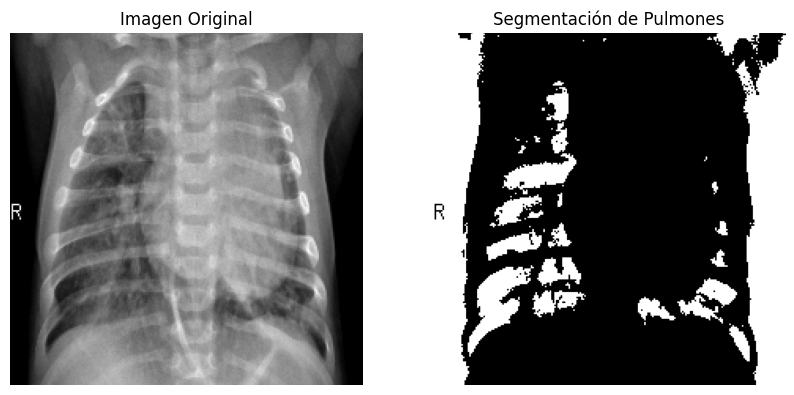

In [ ]:

show_segmentation_example('/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg')  # Cambiar por el archivo que deseas visualizar


In [ ]:
# Evaluar en conjunto de validación
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Precisión en validación: {val_accuracy * 100:.2f}%")


Precisión en validación: 96.65%


Reporte de clasificación:

              precision    recall  f1-score   support

      NORMAL       0.93      0.94      0.93       287
   PNEUMONIA       0.98      0.97      0.97       757

    accuracy                           0.96      1044
   macro avg       0.95      0.96      0.95      1044
weighted avg       0.96      0.96      0.96      1044



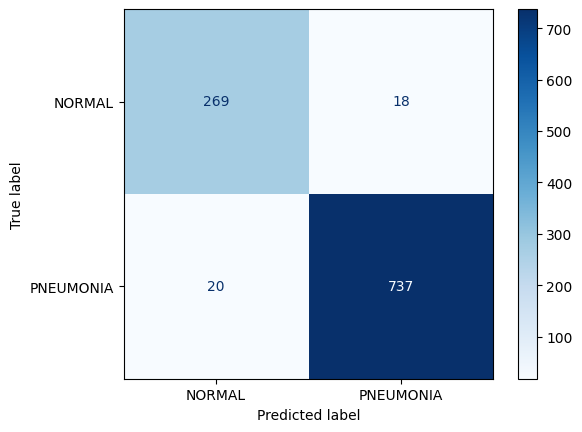

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Calcular el reporte de clasificación
print("Reporte de clasificación:\n")
print(classification_report(y_val, y_val_pred))

# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


**Conclusiones del Reporte de Clasificación**

El modelo tiene una alta precisión general del 96% en el conjunto de datos, lo que indica que el modelo tiene un buen desempeño en la clasificación de imágenes de rayos X de pulmones normales y con neumonía.

**Desempeño por Clases:**
    
* NORMAL: El modelo muestra una precisión de 93%, un recall de 94%, y un F1-score de 93% en la clase "NORMAL". Esto sugiere que el modelo es muy efectivo para identificar imágenes normales, aunque hay un pequeño margen para mejorar el recall, lo que podría aumentar la capacidad de detección de imágenes normales.
* PNEUMONIA: El modelo tiene un desempeño aún mejor en la clase "PNEUMONIA" con una precisión de 98%, un recall de 97%, y un F1-score de 97%. Esto indica que el modelo es muy sensible y preciso al detectar imágenes de neumonía, con un buen balance entre la capacidad de encontrar casos positivos y evitar falsos negativos.

* Promedio Macro: El promedio macro de 95% para precisión, recall y F1-score refleja un equilibrio general en el desempeño del modelo en ambas clases, sin favorecer excesivamente a una clase sobre la otra.

* Promedio Ponderado: El promedio ponderado de 96% confirma que, al considerar el número de muestras de cada clase, el modelo mantiene una excelente capacidad para clasificar correctamente tanto las imágenes normales como las de neumonía, con un desempeño sobresaliente en ambas clases.


En resumen el modelo es altamente efectivo para clasificar imágenes de rayos X de pulmones normales y con neumonía, con un rendimiento particularmente destacado en la detección de neumonía. Aunque hay algo de espacio para mejorar en la identificación de imágenes normales, el modelo en general demuestra ser robusto y confiable para su propósito.